In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna


In [23]:
df = pd.read_csv('../../df_analise_origem_VT.csv')

In [24]:

df.set_index('AnoMes', inplace=True)    

if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp() 
else:
        df.index = pd.to_datetime(df.index)

In [25]:

# Verifique se há valores ausentes e preencha ou remova-os
df = df.dropna()

# Converta todas as colunas para tipos numéricos, se necessário
df = df.apply(pd.to_numeric, errors='coerce')

# Selecione as features (todas as colunas menos 'Vl Liquido Final', 'VL Tabela', 'Vl Bruto')
X = df.drop(columns=['Vl Liquido Final', 'Vl Bruto', 'VL Tabela', 'Origem'])
y = df['Vl Liquido Final']

# Divida os dados em treinamento e teste
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]


In [26]:
print(f"Realizando otimização de hiperparâmetros para Cachoeiro...")

# Definir a função objetivo para o Optuna
def objective(trial):
    # Definir o espaço de busca dos hiperparâmetros
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 3)
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q', 0, 3)
    s = 12  # Período sazonal fixo em 12 (mensal)

    try:
        # Treinar o modelo SARIMAX com os hiperparâmetros sugeridos
        model = SARIMAX(train_y, exog=train_X, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit(disp=False)
        
        # Fazer previsões no conjunto de teste
        forecast_test = model_fit.forecast(steps=len(test_y), exog=test_X)
        
        # Calcular o erro quadrático médio (RMSE)
        rmse = np.sqrt(mean_squared_error(test_y, forecast_test))
    except:
        # Em caso de erro na modelagem, retornar um valor grande
        rmse = np.inf

    return rmse

# Criar o estudo Optuna e executar a otimização
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Obter os melhores hiperparâmetros
best_params = study.best_params
print("Melhores hiperparâmetros encontrados:")
print(best_params)

[I 2024-09-27 08:45:54,537] A new study created in memory with name: no-name-5a78659d-2e06-412a-a4f8-be475fd1f6c4


Realizando otimização de hiperparâmetros para Cachoeiro...


c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum L

Melhores hiperparâmetros encontrados:
{'p': 3, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 0}


c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dudur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dudur\AppData\Local\Temp\ipykernel_21572\1591943361.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test_y.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


Mean Absolute Error (MAE): 949768.43
Root Mean Squared Error (RMSE): 1117998.45
Mean Absolute Percentage Error (MAPE): 15.25%
R-squared (R²): 0.46


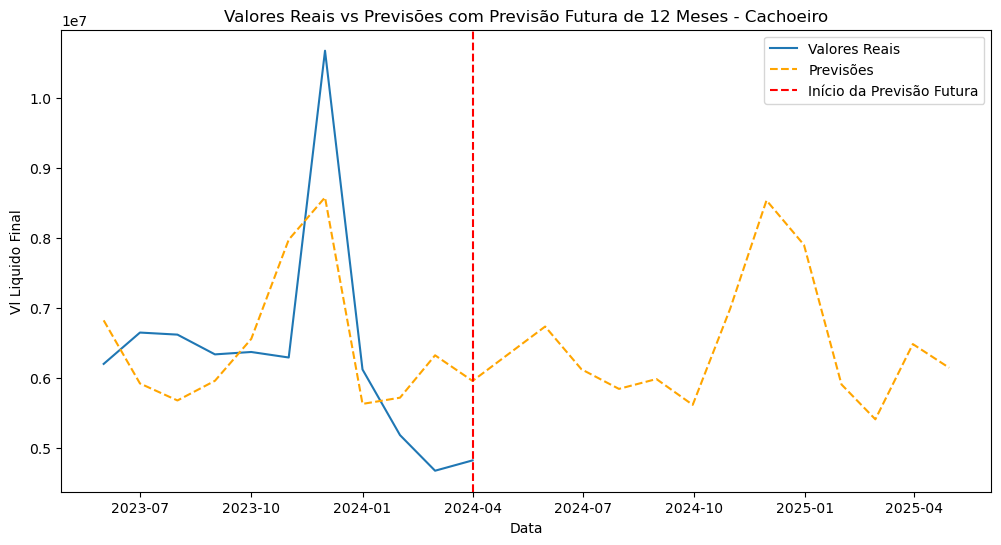

In [27]:
model_best = SARIMAX(train_y, exog=train_X, order=(best_params['p'], best_params['d'], best_params['q']), 
                     seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 12))
model_best_fit = model_best.fit(disp=False)

# Previsão no conjunto de teste com o melhor modelo
forecast_test_best = model_best_fit.forecast(steps=len(test_y), exog=test_X)

# Previsão futura de 12 meses
future_steps = 12
future_dates = pd.date_range(start=test_y.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')
future_X = X.iloc[-future_steps:]  # Assumindo que você tenha dados futuros para as features

forecast_future_best = model_best_fit.forecast(steps=future_steps, exog=future_X)

# Combine previsões de teste e futuras
all_forecast_best = np.concatenate([forecast_test_best, forecast_future_best])
all_dates_best = test_y.index.append(future_dates)

# Calcule as métricas de avaliação
mae = mean_absolute_error(test_y, forecast_test_best)
rmse = np.sqrt(mean_squared_error(test_y, forecast_test_best))
mape = np.mean(np.abs((test_y - forecast_test_best) / test_y)) * 100
r2 = r2_score(test_y, forecast_test_best)

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

# Plotando os valores reais, as previsões e a previsão futura
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y, label='Valores Reais')
plt.plot(all_dates_best, all_forecast_best, label='Previsões', linestyle='--', color='orange')
plt.axvline(x=test_y.index[-1], color='red', linestyle='--', label='Início da Previsão Futura')
plt.xlabel('Data')
plt.ylabel('Vl Liquido Final')
plt.title(f'Valores Reais vs Previsões com Previsão Futura de 12 Meses - Cachoeiro')
plt.legend()
plt.show()
